In [1]:
import zipfile
from PIL import Image
import io
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import random

C:\Users\28612\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load Datasets

In [2]:
high_path = './high-quality'
low_path = './low-quality'
categories = ['real', 'fake']

data_high = []
data_low = []

for category in categories:
    high_folder_path = os.path.join(high_path, category)
    low_folder_path = os.path.join(low_path, category)
    label = 1 if category == 'real' else 0

    for file in os.listdir(high_folder_path):
        if file.endswith(('jpg', 'png', 'jpeg')):  
            file_path = os.path.join(high_folder_path, file)
            image = Image.open(file_path)
            data_high.append((image, label))
            
    for file in os.listdir(low_folder_path):
        if file.endswith(('jpg', 'png', 'jpeg')):  
            file_path = os.path.join(low_folder_path, file)
            image = Image.open(file_path)
            data_low.append((image, label))

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: './high-quality\\real'

## Show data examples : High quality 

In [ ]:

# Hight qulity 1 means real, 0 means fake

plt.subplot(2, 2, 1)  
plt.imshow(data_high[0][0], cmap='gray') 
plt.title(f'High quality Image 1: { data_high[0][1] }') 

plt.subplot(2, 2, 2) 
plt.imshow(data_high[1][0], cmap='gray')  
plt.title(f'High quality Image 2: { data_high[1][1] }') 
plt.show() 

plt.subplot(2, 2, 3)  
plt.imshow(data_high[1000][0], cmap='gray') 
plt.title(f'High quality Image 1000: { data_high[1000][1] }') 

plt.subplot(2, 2, 4) 
plt.imshow(data_high[1001][0], cmap='gray')  
plt.title(f'High quality Image 1001: { data_high[1001][1] }') 
plt.show() 

## Show data examples : Low quality 

In [ ]:
# Low qulity 1 means real, 0 means fake

plt.subplot(2, 2, 1)  
plt.imshow(data_low[0][0], cmap='gray') 
plt.title(f'Low quality Image 1: { data_low[0][1] }') 

plt.subplot(2, 2, 2) 
plt.imshow(data_low[1][0], cmap='gray')  
plt.title(f'Low quality Image 2: { data_low[1][1] }') 
plt.show() 

plt.subplot(2, 2, 3)  
plt.imshow(data_low[1000][0], cmap='gray') 
plt.title(f'Low quality Image 1000: { data_low[1000][1] }') 

plt.subplot(2, 2, 4) 
plt.imshow(data_low[1001][0], cmap='gray')  
plt.title(f'Low quality Image 10001: { data_low[1001][1] }') 
plt.show() 

# Preprocess with clahe

In [ ]:
#The order of elements in the list is disrupted
random.shuffle(data_high)
random.shuffle(data_low)

In [ ]:
def build_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        # predicte: clip_limit & tile_grid_size
        layers.Dense(2, activation='linear')
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [ ]:
def preprocess_data(data):
    processed_images = []
    labels = []
    for image, label in data:
        # adjust size
        image = np.array(image.resize((180, 180)))
        # Normalization
        image = image.astype(np.float32) / 255.0
        processed_images.append(image)
        labels.append(label)
    return np.array(processed_images), np.array(labels)

processed_high, labels_high = preprocess_data(data_high)
processed_low, labels_low = preprocess_data(data_low)

In [3]:
def apply_clahe(image, clip_limit,tile_grid_size):
    img_np = np.array(image)
    img_np = img_np[:, :, ::-1]  # Convert RGB to BGR
    img_lab = cv2.cvtColor(img_np, cv2.COLOR_BGR2Lab)  # Convert to Lab color space
    l, a, b = cv2.split(img_lab)  # Split into channels
    tile_grid_size_int = int(tile_grid_size)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_grid_size_int, tile_grid_size_int))  # Apply CLAHE with specified parameters
    l_clahe = clahe.apply(l)  # Apply to L channel
    lab_clahe = cv2.merge((l_clahe, a, b))  # Merge back the channels
    img_clahe_bgr = cv2.cvtColor(lab_clahe, cv2.COLOR_Lab2BGR)  # Convert back to BGR
    img_clahe_rgb = img_clahe_bgr[:, :, ::-1]  # Convert BGR to RGB
    return Image.fromarray(img_clahe_rgb)

In [4]:
def enhance_images(data,clip_limit,tile_grid_size):
    enhanced_images = []
    enhanced_images_label = []
    for i in range(len(data)):
        enhanced_image = apply_clahe(data[i][0], clip_limit,tile_grid_size)
        enhanced_images.append(enhanced_image)
        enhanced_images_label.append(data[i][1])
    return enhanced_images,enhanced_images_label

enhanced_images_high,enhanced_high_label = enhance_images(data_high,15,7)
enhanced_images_low,enhanced_low_label = enhance_images(data_low,15,7)

# Get CLAHE parameters : clip_limit, tile_grid_size

In [128]:
def generate_synthetic_clahe_params(num_samples):
     # Generating machine image brightness index, different illumination conditions
    brightness_levels = np.random.rand(num_samples)
     # Clip_limit according to the calculation of the original brightness, clip_limit according to the demand of the dark image
    clip_limits = 1 + 3 * (1 - brightness_levels) # clip_limit
     # Generating machine coherence index, model dissimilar coherence strength
    texture_levels = np.random.rand(num_samples)
     # Root construction calculation tile_grid_size, calculation construction calculation tile_grid_size, calculation tile_grid_size calculation tile_grid_size
    tile_grid_sizes = 8 + (8 * (1 - texture_levels)).astype(int) # tile_grid_size范围从8到16
    return np.vstack((clip_limits, tile_grid_sizes)).T


x_data = np.array(processed_low)  
num_images = len(processed_low)
y_data = generate_synthetic_clahe_params(num_images)
input_shape = x_data.shape[1:] 
model = build_model(input_shape)

# y_data is CLAHE parameters
model.fit(x_data, y_data, batch_size=32, epochs=10, validation_split=0.2)
y_pred_best_low = model.predict(x_data)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step - loss: 17.6576 - mae: 2.9695 - val_loss: 4.2918 - val_mae: 1.5303
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - loss: 3.4370 - mae: 1.4220 - val_loss: 3.2381 - val_mae: 1.3929
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 247ms/step - loss: 3.0422 - mae: 1.3546 - val_loss: 3.1170 - val_mae: 1.3758
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 250ms/step - loss: 3.0007 - mae: 1.3490 - val_loss: 3.2679 - val_mae: 1.4072
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - loss: 2.8724 - mae: 1.3157 - val_loss: 3.5031 - val_mae: 1.4519
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - loss: 2.5168 - mae: 1.2081 - val_loss: 3.8047 - val_mae: 1.4872
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - loss: 2.1291 - mae: 1.0975 - val_loss: 3.6576 - val_mae: 1.4646
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - loss: 1.6614 - mae: 0.9475 - val_loss: 4.2033 - val_mae: 1.5359
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms

In [129]:
print(y_pred_best_low.shape)
print(y_pred_best_low[:5])

(1727, 2)
[[ 3.318075  12.666612 ]
 [ 1.8113514  8.513837 ]
 [ 2.735128  10.751085 ]
 [ 1.691299   8.213488 ]
 [ 3.131017   9.946233 ]]


# Apply CLAHE

In [150]:
def enhance_images(data,y_pred_best_low):
    enhanced_images = []
    enhanced_images_label = []
    for i in range(len(data)):
        enhanced_image = apply_clahe(data[i][0],y_pred_best_low[i][0],y_pred_best_low[i][1])
        enhanced_images.append(enhanced_image)
        enhanced_images_label.append(data[i][1])
    return enhanced_images,enhanced_images_label

#enhanced_images_high,enhanced_high_label = enhance_images(data_high,15,7)
enhanced_images_low,enhanced_low_label = enhance_images(data_low,y_pred_best_low)

In [151]:
len(enhanced_images_low)

1727

In [154]:
print(enhanced_images_low[:3])
print(enhanced_low_label[:3])

[<PIL.Image.Image image mode=RGB size=256x256 at 0x139C7DA3E50>, <PIL.Image.Image image mode=RGB size=256x256 at 0x13A6929F5E0>, <PIL.Image.Image image mode=RGB size=256x256 at 0x13A6951F0A0>]
[0, 1, 0]


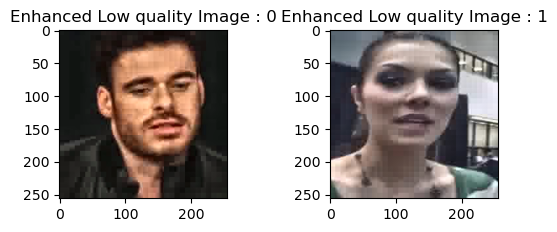

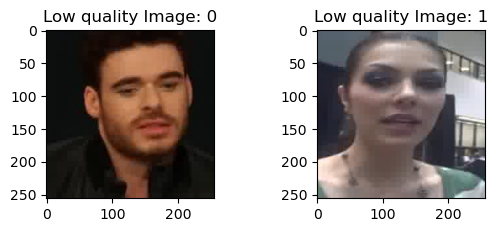

In [159]:
plt.subplot(2, 2, 1)  
plt.imshow(enhanced_images_low[0], cmap='gray') 
plt.title(f'Enhanced Low quality Image : { enhanced_low_label[0] }') 

plt.subplot(2, 2, 2) 
plt.imshow(enhanced_images_low[1], cmap='gray')  
plt.title(f'Enhanced Low quality Image : { enhanced_low_label[1] }') 
plt.show() 

plt.subplot(2, 2, 3)  
plt.imshow(data_low[0][0], cmap='gray') 
plt.title(f'Low quality Image: { data_low[0][1] }') 

plt.subplot(2, 2, 4) 
plt.imshow(data_low[1][0], cmap='gray')  
plt.title(f'Low quality Image: { data_low[1][1] }') 
plt.show() 


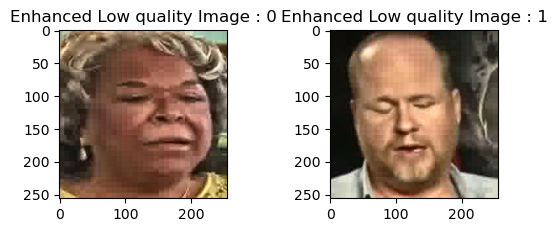

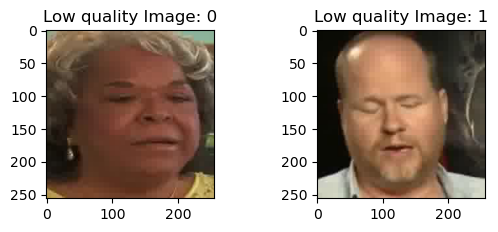

In [160]:
plt.subplot(2, 2, 1)  
plt.imshow(enhanced_images_low[2], cmap='gray') 
plt.title(f'Enhanced Low quality Image : { enhanced_low_label[2] }') 

plt.subplot(2, 2, 2) 
plt.imshow(enhanced_images_low[3], cmap='gray')  
plt.title(f'Enhanced Low quality Image : { enhanced_low_label[3] }') 
plt.show() 

plt.subplot(2, 2, 3)  
plt.imshow(data_low[2][0], cmap='gray') 
plt.title(f'Low quality Image: { data_low[2][1] }') 

plt.subplot(2, 2, 4) 
plt.imshow(data_low[3][0], cmap='gray')  
plt.title(f'Low quality Image: { data_low[3][1] }') 
plt.show() 

# Build Model

In [177]:

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout

def build_model(input_shape):

    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    base_model.trainable = False


    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2, activation='softmax')(x)  

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

input_shape = (180, 180, 3)  
model = build_model(input_shape)
model.summary()


C:\Users\28612\AppData\Local\Temp\ipykernel_33236\1129653197.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 90, 90,    │        864 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 90, 90,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 90, 90,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 90, 90,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 90, 90,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 90, 90,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 90, 90,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 90, 90,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 90, 90,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 90, 90,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 90, 90,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 91, 91,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 45, 45,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 45, 45,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 45, 45,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 45, 45,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Train Model on low quality enhanced images

In [162]:
def preprocess_data_after(enhanced_images):
    processed_images = []
    for image in enhanced_images:
        image = np.array(image.resize((180, 180)))
        # Normalization
        image = image.astype(np.float32) / 255.0
        processed_images.append(image)
    return np.array(processed_images)

In [167]:
X_low = preprocess_data_after(enhanced_images_low)
y_low = np.array(enhanced_low_label)
print(X_low.shape)
print(y_low.shape)

(1727, 180, 180, 3)
(1727,)


In [169]:
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(X_low, y_low, test_size=0.2) #enhanced
X_train_low_raw, X_test_low_raw, y_train_low_raw, y_test_low_raw = train_test_split(processed_low, labels_low, test_size=0.2) #raw

In [179]:
print(X_train_low.shape)
print(X_train_low_raw.shape)

(1381, 180, 180, 3)
(1381, 180, 180, 3)


In [178]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, batch_size=32, epochs=10):
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

model = build_model(input_shape=(180, 180, 3))

C:\Users\28612\AppData\Local\Temp\ipykernel_33236\1129653197.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.4828 - loss: 1.0021 - val_accuracy: 0.5723 - val_loss: 0.6817
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.6073 - loss: 0.6991 - val_accuracy: 0.6445 - val_loss: 0.6328
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.6653 - loss: 0.6142 - val_accuracy: 0.6965 - val_loss: 0.5860
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.7032 - loss: 0.5564 - val_accuracy: 0.6879 - val_loss: 0.5645
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.7177 - loss: 0.5425 - val_accuracy: 0.7399 - val_loss: 0.5646
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.7277 - loss: 0.5310 - val_accuracy: 0.7370 - val_loss: 0.5480
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.7511 - loss: 0.4913 - val_accuracy: 0.7514 - val_loss: 0.5549
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.7936 - loss: 0.4653 - val_accuracy: 0

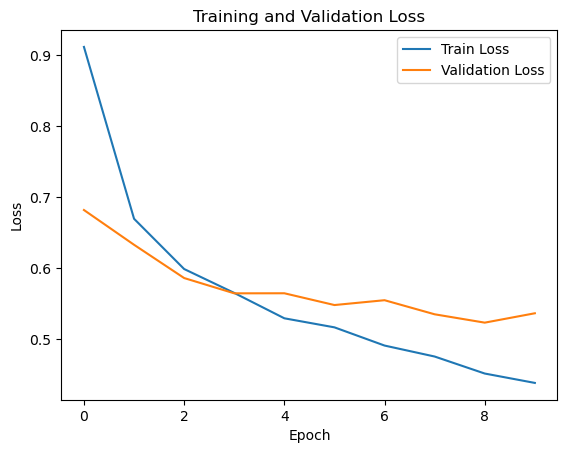

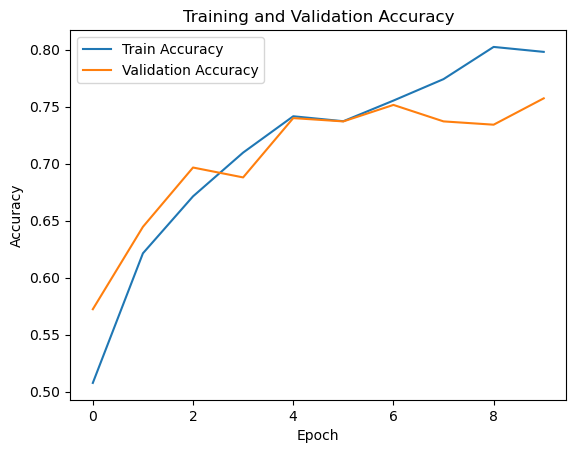

In [180]:
train_and_evaluate_model(model,X_train_low,y_train_low,X_test_low,  y_test_low)

# Train Model on low quality raw images

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.7975 - loss: 0.4718 - val_accuracy: 0.7630 - val_loss: 0.4622
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.7901 - loss: 0.4675 - val_accuracy: 0.7948 - val_loss: 0.4409
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.8020 - loss: 0.4614 - val_accuracy: 0.7832 - val_loss: 0.4440
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.7810 - loss: 0.4531 - val_accuracy: 0.8092 - val_loss: 0.4299
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.8261 - loss: 0.4186 - val_accuracy: 0.7948 - val_loss: 0.4272
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.8004 - loss: 0.4369 - val_accuracy: 0.8179 - val_loss: 0.4221
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - accuracy: 0.8303 - loss: 0.3861 - val_accuracy: 0.8092 - val_loss: 0.4200
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.8591 - loss: 0.3669 - val_accuracy: 0.

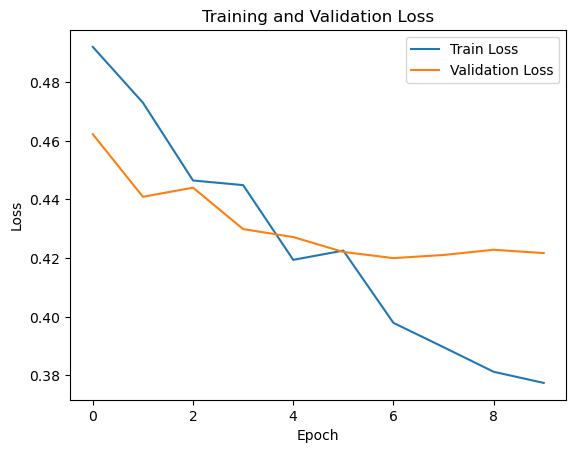

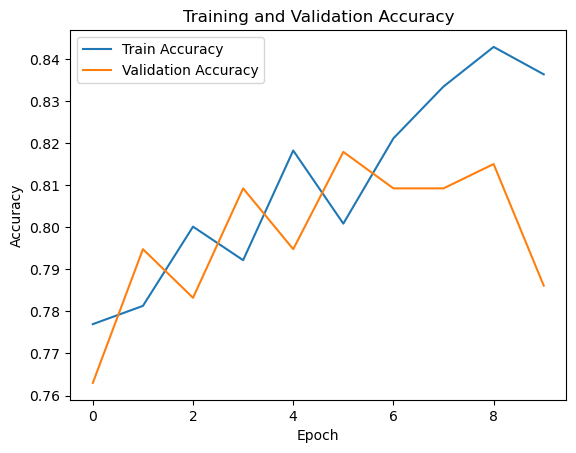

In [181]:
train_and_evaluate_model(model,X_train_low_raw, y_train_low_raw,X_test_low_raw, y_test_low_raw)

# Train Model on high quality processed images

# Train Model on high quality raw images